### Introduction

In this project, we used the CICIDS2017 dataset, which provides a realistic representation of both benign network activity and common cyberattacks, captured over five days. This dataset includes diverse attack types such as brute force, DoS, and DDoS attacks, along with benign traffic generated to simulate real-world conditions. The dataset comprises 15 target classes, including both benign traffic and various cyberattacks. However, there is a significant class imbalance: benign traffic accounts for 80% of the dataset, while cyberattacks make up only 20%. Additionally, there is a large imbalance among the different types of attacks within the dataset.

Our approach involved two main stages: first, preprocessing the dataset and applying machine learning algorithms to classify the data as either benign or malicious. Once the cyberattacks were identified, we then aimed to predict the specific type of attack. This report outlines our methodology and findings from these analyses.

### Methodology

##### 1. Pre-processing to classify observations as either benign or malicious. 

The first stage of our methodology was to classify each observation as either benign or malicious. To achieve this, we implemented a series of preprocessing steps to prepare the data for machine learning algorithms:

**Data Cleaning**: We filtered out rows containing values such as infinity, NaN, or other characters that were inconsistent with the context of the dataset. This ensured that the data was clean and ready for further processing.

**Data Rescaling**: We used the Standard Scaler to rescale the data. This normalization technique ensured that all features were on the same scale, which is crucial for machine learning algorithms that are sensitive to feature magnitudes.

**Multicollinearity Resolution**: We addressed multicollinearity by generating a correlation matrix and corresponding plot to identify highly correlated features. Only independent variables were retained, as multicollinearity can distort model performance and interpretability. To address this issue, we first analyzed the correlation matrix of the features in the dataset to identify highly correlated columns. Multicollinearity occurs when two or more predictor variables are highly correlated, leading to redundancy and reduced model performance. Our objective was to retain only the most representative variables and remove the others, as the presence of highly correlated features can skew the predictive power of the model.

Step-by-Step Approach:
Identifying Highly Correlated Columns: We first counted the number of columns each feature was correlated with, using a threshold correlation value. For features that were correlated with six or more columns (i.e., cols_with_high_corr_grade), we identified them for further inspection. These features represented variables that had strong relationships with many other variables in the dataset, potentially introducing redundancy.

Visualizing Correlation: To visually inspect the strength of correlations among the highly correlated features, we generated a heatmap. This helped us quickly spot groups of highly correlated variables and allowed us to make informed decisions about which features to drop and which to retain.

Retaining Representative Features: From the highly correlated columns, we decided to retain only three representative columns: Flow Duration, Bwd Packet Length Mean, and Total Backward Packets. These columns were chosen because they captured the key information required to predict the other features that we dropped. By keeping these three, we ensured minimal information loss while reducing multicollinearity.

Dropping Redundant Columns: After selecting the representative columns, we removed the rest of the highly correlated features (those that we could predict almost perfectly using the retained columns). These columns were appended to the list of features to be dropped.

Low-Correlation Columns: We also analyzed columns with lower correlations (less than six correlated features, i.e., cols_with_low_corr_grade) to ensure they did not introduce further multicollinearity. Using another heatmap for visualization, we identified additional features to drop, including variables like Fwd IAT Min, Bwd IAT Mean, and Fwd Packet Length Max, among others.

Final Multicollinearity Check: After dropping the highly correlated features, we recalculated the correlation matrix for the remaining columns to ensure that no further high correlations existed. We identified a few additional features with correlation values above our predefined threshold of 0.7. These features (e.g., Total Length of Fwd Packets, Fwd PSH Flags, Bwd IAT Min) were also dropped to ensure that the final feature set was free from significant multicollinearity.

Result: Through this process, we successfully reduced multicollinearity by retaining only the most informative features and removing redundant variables. This allowed us to improve the efficiency and accuracy of our machine learning models by ensuring that the input features were independent and non-redundant.

**Feature Selection**: We used two feature selection techniques: Lasso (L1) regularization and Recursive Feature Elimination (RFE). After testing both, we implemented the Lasso regularization method, as it provided better results in identifying the most useful features for predictions.

These preprocessing steps allowed us to effectively prepare the dataset for classification tasks, ensuring that the model was trained on relevant, scaled, and independent features.

### Predictions on binary classification problem
In the next phase of the project, we focused on making predictions using several machine learning algorithms: Logistic Regression, Naive Bayes, Decision Tree, and K-Nearest Neighbors (KNN).

Each of these models demonstrated solid performance, both when all features were included and when features were excluded based on the L1 regularization results. However, among them, the Decision Tree model stood out as the best-performing algorithm. Its strength was evident not only in terms of overall accuracy but particularly in its recall for the sensitive class—the identification of cyberattacks. The Decision Tree managed to capture almost all instances of cyberattacks, which is crucial for minimizing false negatives in a cybersecurity context. This high recall ensured that nearly no cyberattacks went undetected.

By balancing accuracy and recall, the Decision Tree proved to be the most effective model for our classification task.

 --------------------------------------------------------------------------------------------------------------------------------------------------------------
 
##### 2. Pre-processing to classify cyberattacks by type. 

In this section, the only additional preprocessing step was the use of a Label Encoder to convert the target labels into numerical values. We then implemented the same algorithms as in the binary classification task, adjusting the parameters accordingly. The top-performing algorithm for this multi-class classification was again the Decision Tree classifier, achieving an accuracy score of 99.27%, followed by K-Nearest Neighbors (KNN) with an accuracy of 98%. However, most of the incorrect predictions occurred in the underrepresented target classes. The other algorithms had significantly lower performance, with Logistic Regression achieving around 45% accuracy, and Naive Bayes around 31%.

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

In [2]:
base_dir = Path.cwd()
ml_path = base_dir / "MachineLearningCVE"
dataframes = []
for csv in ml_path.rglob("*.csv"):
    df = pd.read_csv(csv)
    print(csv.name, " is loaded")
    dataframes.append(df)
df = pd.concat(dataframes)
df.columns = [col.strip() for col in df.columns]

Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  is loaded
Monday-WorkingHours.pcap_ISCX.csv  is loaded
Friday-WorkingHours-Morning.pcap_ISCX.csv  is loaded
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  is loaded
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  is loaded
Tuesday-WorkingHours.pcap_ISCX.csv  is loaded
Wednesday-workingHours.pcap_ISCX.csv  is loaded
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  is loaded


In [3]:
for i in df.columns:
    df = df[df[i] != np.inf]
    df = df[df[i] != np.nan]
    df = df[df[i] != ",,"]
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

In [4]:
df.drop(columns="Destination Port", inplace=True)

In [5]:
df.shape

(2827876, 78)

In [6]:
df["Label"].value_counts()

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In this section we will prepare the data in order to predict if a cyberattack occurs or not.  

Meaning, we will attempt to make predictions on a binary classification problem.
We will set 'BENIGN' as 0 and every attack will have a value of 1.

The reason that we initially model the problem like that is due to huge class imbalance.

For example, the cyberattack type "Bot" is underrepresented  compared to other attacks and in general, all the attacks are underrepresented compared to the benign traffic.

In [7]:
df["NumericLabel"] = df["Label"].apply(lambda value: 0 if value == "BENIGN" else 1)
df["NumericLabel"].value_counts()

NumericLabel
0    2271320
1     556556
Name: count, dtype: int64

In [8]:
attacks_percentage = df["NumericLabel"].sum() / len(df["NumericLabel"])
print("Cyberattacks percentage against benign traffic within the dataset:", f"{attacks_percentage *100:.2f}%")

Cyberattacks percentage against benign traffic within the dataset: 19.68%


Notice that even when the problem is binary and, we care only if an attack took place the dataset is still imbalance.

Another problem is that there are many columns as features but, we do not know if they have any contribution in our prediction problem. 

The section below will be dedicated to the selection of the most important features. We will implement :

1. L1 Regularization (Lasso)
Lasso Regression is a linear model that includes an L1 penalty. This penalty tends to shrink the coefficients of less important features to zero, effectively performing feature selection.
This is useful for high-dimensional data where you suspect that only a small number of features are important.

2. Recursive Feature Elimination (RFE)
RFE is a feature selection method that recursively fits a model (e.g., a linear model or a tree-based model) and removes the least important feature, repeating the process until the desired number of features is reached.
Implementation: Use RFE with a classifier to rank features and eliminate less important ones.

Moreover, the proper implementation of these techniques requires the re-scaling of the data so each column will have 0 as mean value and unit variance. This can be achieved via StandardScaler.

``The implementation of L1 Regularization is kept as the approach for feature selection as it provided better results.``

In [9]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["Label", "NumericLabel"]).values
y = df["NumericLabel"]

scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

### Lasso Regression

Lasso Regression results can be highly affected when multi-colinearity exists in the dataframe. Let's visualise how the features are correlated one with another.

In [10]:
scaled_df = pd.DataFrame(scaled_X, columns=df.drop(columns=["Label", "NumericLabel"]).columns)
correlation_matrix = scaled_df.corr()
correlation_matrix

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Flow Duration,1.000000,0.020854,0.019667,0.065439,0.016185,0.273221,-0.105380,0.143584,0.234361,0.497540,...,0.015940,-0.001356,0.189263,0.241038,0.294000,0.121138,0.768001,0.243131,0.779494,0.738292
Total Fwd Packets,0.020854,1.000000,0.999070,0.365508,0.996993,0.009355,-0.002992,0.000029,0.001401,0.022817,...,0.887387,-0.000184,0.039936,0.008328,0.030457,0.041282,0.001816,0.000808,0.001902,0.001667
Total Backward Packets,0.019667,0.999070,1.000000,0.359451,0.994429,0.009036,-0.002603,-0.000336,0.001024,0.022591,...,0.882566,0.000018,0.038962,0.006436,0.028601,0.041277,0.001422,0.000491,0.001452,0.001326
Total Length of Fwd Packets,0.065439,0.365508,0.359451,1.000000,0.353762,0.197022,-0.000292,0.185258,0.159779,0.023221,...,0.407448,-0.001209,0.101078,0.103321,0.126486,0.068319,0.022642,0.027058,0.026061,0.018617
Total Length of Bwd Packets,0.016185,0.996993,0.994429,0.353762,1.000000,0.006611,-0.002185,-0.001447,-0.000472,0.021952,...,0.883967,0.000018,0.035955,0.003492,0.024837,0.039068,0.000806,0.000104,0.000795,0.000787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Active Min,0.121138,0.041282,0.041277,0.068319,0.039068,0.105617,-0.025944,0.081146,0.094143,0.073169,...,0.031394,-0.006834,0.905861,0.033863,0.584497,1.000000,0.118105,0.038292,0.122623,0.112853
Idle Mean,0.768001,0.001816,0.001422,0.022642,0.000806,0.181053,-0.071417,0.127872,0.183071,0.577110,...,0.000835,-0.000875,0.120135,0.036516,0.088858,0.118105,1.000000,0.150219,0.990386,0.990214
Idle Std,0.243131,0.000808,0.000491,0.027058,0.000104,0.178069,-0.029987,0.178442,0.191258,0.170744,...,0.000720,-0.003719,0.070573,0.081424,0.069987,0.038292,0.150219,1.000000,0.283310,0.011572
Idle Max,0.779494,0.001902,0.001452,0.026061,0.000795,0.199478,-0.073534,0.148317,0.203237,0.582075,...,0.000926,-0.001406,0.132664,0.055266,0.102770,0.122623,0.990386,0.283310,1.000000,0.961807


In [11]:
scaled_df.shape

(2827876, 77)

In [12]:
# Let's find which columns are highly correlated one another.
threshold = 0.7
# Key is a column and the value is a list with the columns with above 0.7 correlation
highly_correlated_columns = defaultdict(list)
# Count the number of highly correlated columns for each column
correlation_count = defaultdict(int)

for key_col, row in correlation_matrix.iterrows():
    for with_column in row.index:
        correlation_value = row[with_column]
        if abs(correlation_value) > threshold and key_col != with_column:
            highly_correlated_columns[key_col].append((with_column, correlation_value))
            correlation_count[key_col] += 1

correlation_count = dict(sorted(correlation_count.items(), key=lambda item: item[1], reverse=True))

For example Flow IAT std is founded to be correlated with 10 columns

In [13]:
correlation_count

{'Flow IAT Std': 10,
 'Flow Duration': 9,
 'Fwd IAT Total': 9,
 'Bwd Packet Length Max': 8,
 'Bwd Packet Length Mean': 8,
 'Bwd Packet Length Std': 8,
 'Flow IAT Max': 8,
 'Fwd IAT Std': 8,
 'Fwd IAT Max': 8,
 'Max Packet Length': 8,
 'Packet Length Mean': 8,
 'Packet Length Std': 8,
 'Packet Length Variance': 8,
 'Average Packet Size': 8,
 'Avg Bwd Segment Size': 8,
 'Idle Mean': 8,
 'Idle Max': 8,
 'Idle Min': 8,
 'Total Fwd Packets': 6,
 'Total Backward Packets': 6,
 'Total Length of Bwd Packets': 6,
 'Subflow Fwd Packets': 6,
 'Subflow Bwd Packets': 6,
 'Subflow Bwd Bytes': 6,
 'act_data_pkt_fwd': 6,
 'Fwd IAT Mean': 5,
 'Fwd IAT Min': 4,
 'Bwd IAT Mean': 4,
 'Fwd Packet Length Max': 3,
 'Fwd Packet Length Mean': 3,
 'Fwd Packet Length Std': 3,
 'Flow IAT Mean': 3,
 'Bwd IAT Total': 3,
 'Bwd IAT Max': 3,
 'Bwd IAT Min': 3,
 'Avg Fwd Segment Size': 3,
 'Active Mean': 2,
 'Active Max': 2,
 'Total Length of Fwd Packets': 1,
 'Bwd Packet Length Min': 1,
 'Flow Packets/s': 1,
 'Bwd IAT 

<Axes: >

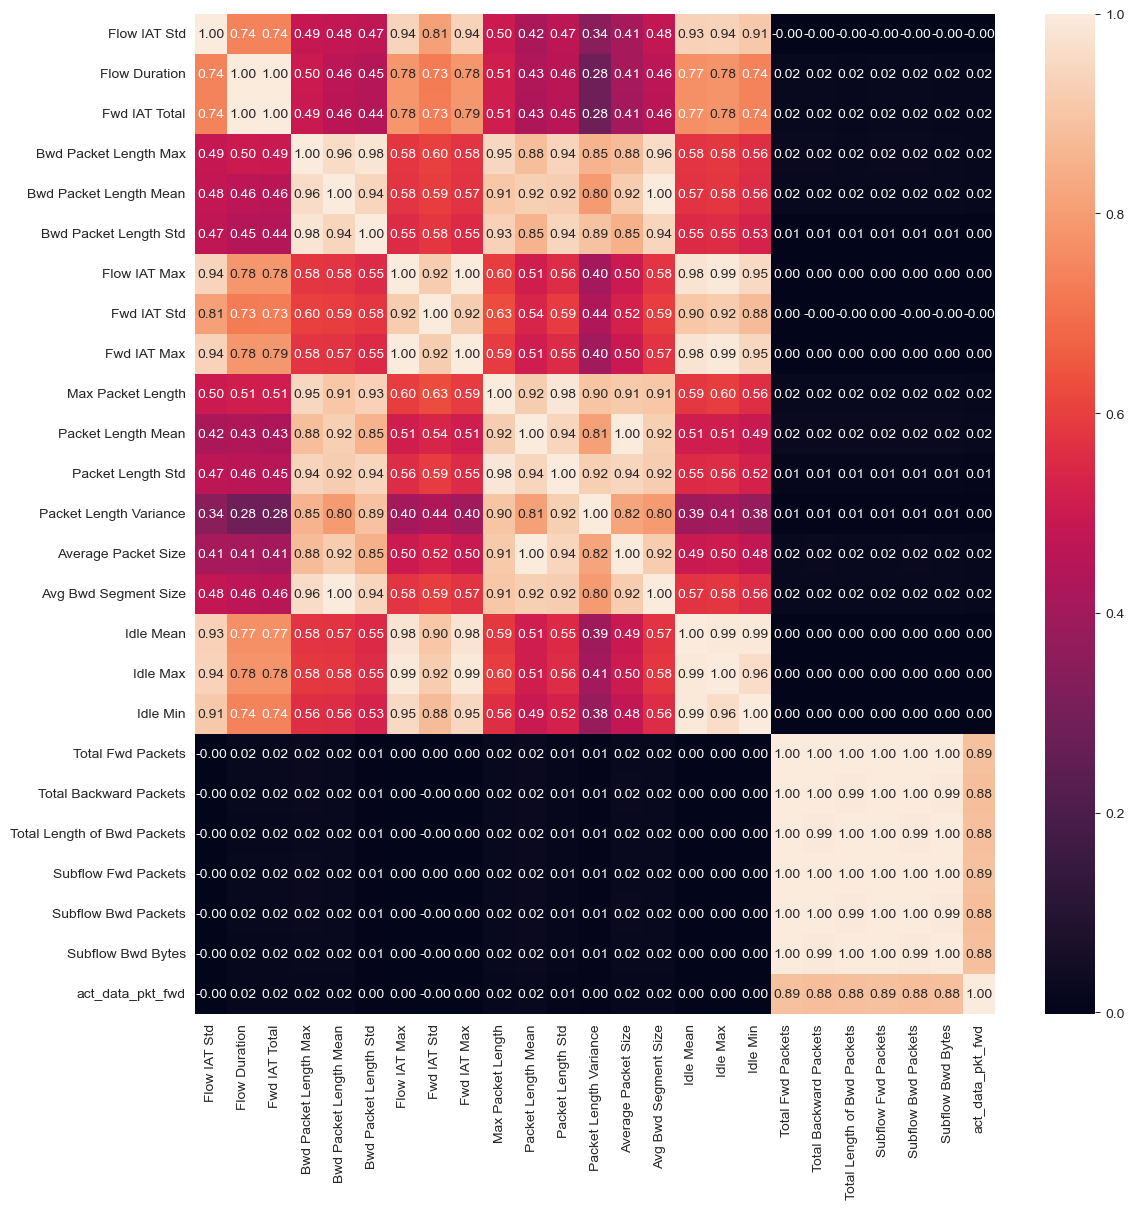

In [14]:
# Let's find the columns that are highly correlated with more than six other columns within the dataset
cols_with_high_corr_grade = []
for key, value in correlation_count.items():
    if value >= 6:
        cols_with_high_corr_grade.append(key)

new_corr_matrix = scaled_df[cols_with_high_corr_grade].corr()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])
sns.heatmap(new_corr_matrix, annot=True, fmt=".2f", ax=ax)

From the highly correlated columns we can keep only three columns:
1. Flow Duration
2. Bwd Backet Length Mean
3. Total Backward Packets.

By keeping only these three columns I can predict all the other that I will drop almost perfectly.

In [15]:
cols_with_high_corr_grade.remove("Flow Duration")
cols_with_high_corr_grade.remove("Bwd Packet Length Mean")
cols_with_high_corr_grade.remove("Total Backward Packets")

In [16]:
len(cols_with_high_corr_grade)  # number of columns that we will drop

22

<Axes: >

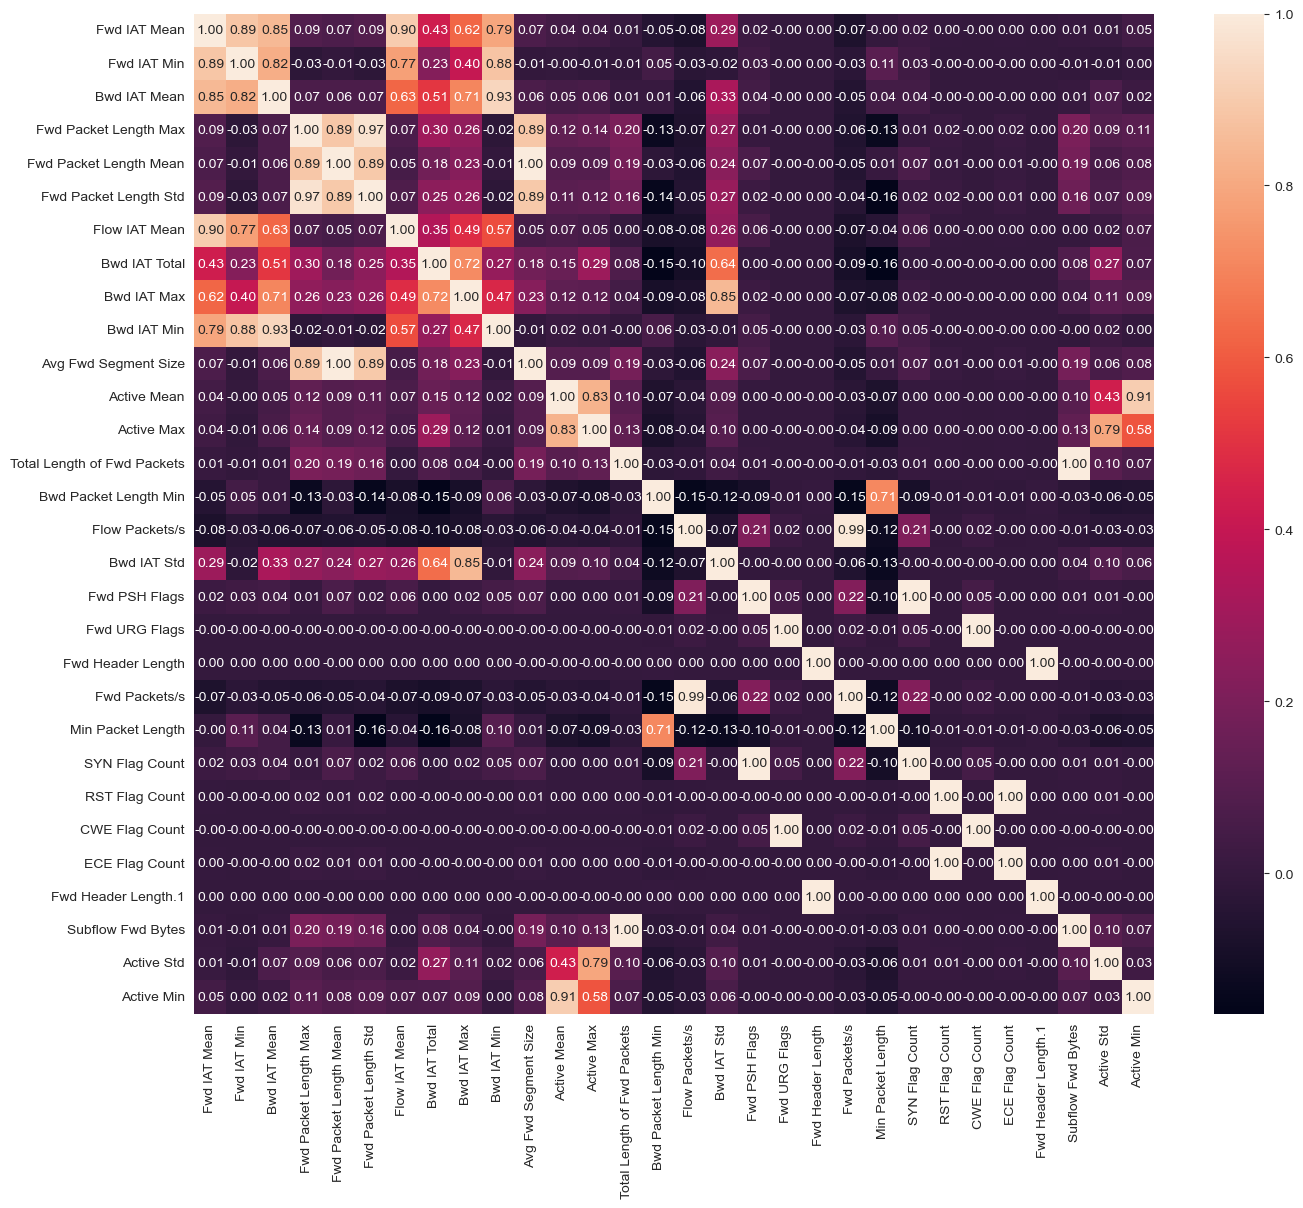

In [17]:
cols_with_low_corr_grade = [key for key, value in correlation_count.items() if value < 6]

new_corr_matrix = scaled_df[cols_with_low_corr_grade].corr()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0, 0, 1, 1])
sns.heatmap(new_corr_matrix, annot=True, fmt=".2f", ax=ax)

From the columns with low correlation_grade we will drop:
1. Fwd IAT Min
2. Bwd Iat Mean
3. Fwd Fwd Packet Length Max
4. Fwd Packet Length Std
5. Bwd IAT Max
6. Avg Fwd Segment Size
7. Active Max
8. Active Min
9. Fwd Header Length.1
10. Min Packet Length
11. Fwd Packets/s

In [18]:
columns_to_drop = [
    "Fwd IAT Min",
    "Bwd IAT Mean",
    "Fwd Packet Length Max",
    "Fwd Packet Length Std",
    "Bwd IAT Max",
    "Avg Fwd Segment Size",
    "Active Max",
    "Active Min",
    "Fwd Header Length.1",
    "Min Packet Length",
    "Fwd Packets/s",
]


# Check for typos
for col in columns_to_drop:
    try:
        scaled_df.drop(columns=[col])
    except KeyError:
        print(col)

In [19]:
# Append the columns to drop
columns_to_drop += cols_with_high_corr_grade

In [20]:
len(columns_to_drop)

33

In [21]:
scaled_df = scaled_df.drop(columns=columns_to_drop)

In [22]:
scaled_df.shape

(2827876, 44)

Now let's redo the same procedure to find the correlated columns. We have not taken into consideration the correlation among columns with high and low correlation grade.

In [23]:
# Let's find which columns are still highly correlated one another after dropping some columns.
threshold = 0.7
highly_correlated_columns = defaultdict(list)
correlation_count = defaultdict(int)


correlation_matrix = scaled_df.corr()

for key_col, row in correlation_matrix.iterrows():
    for with_column in row.index:
        correlation_value = row[with_column]
        if abs(correlation_value) > threshold and key_col != with_column:
            highly_correlated_columns[key_col].append((with_column, correlation_value))
            correlation_count[key_col] += 1

correlation_count = dict(sorted(correlation_count.items(), key=lambda item: item[1], reverse=True))

<Axes: >

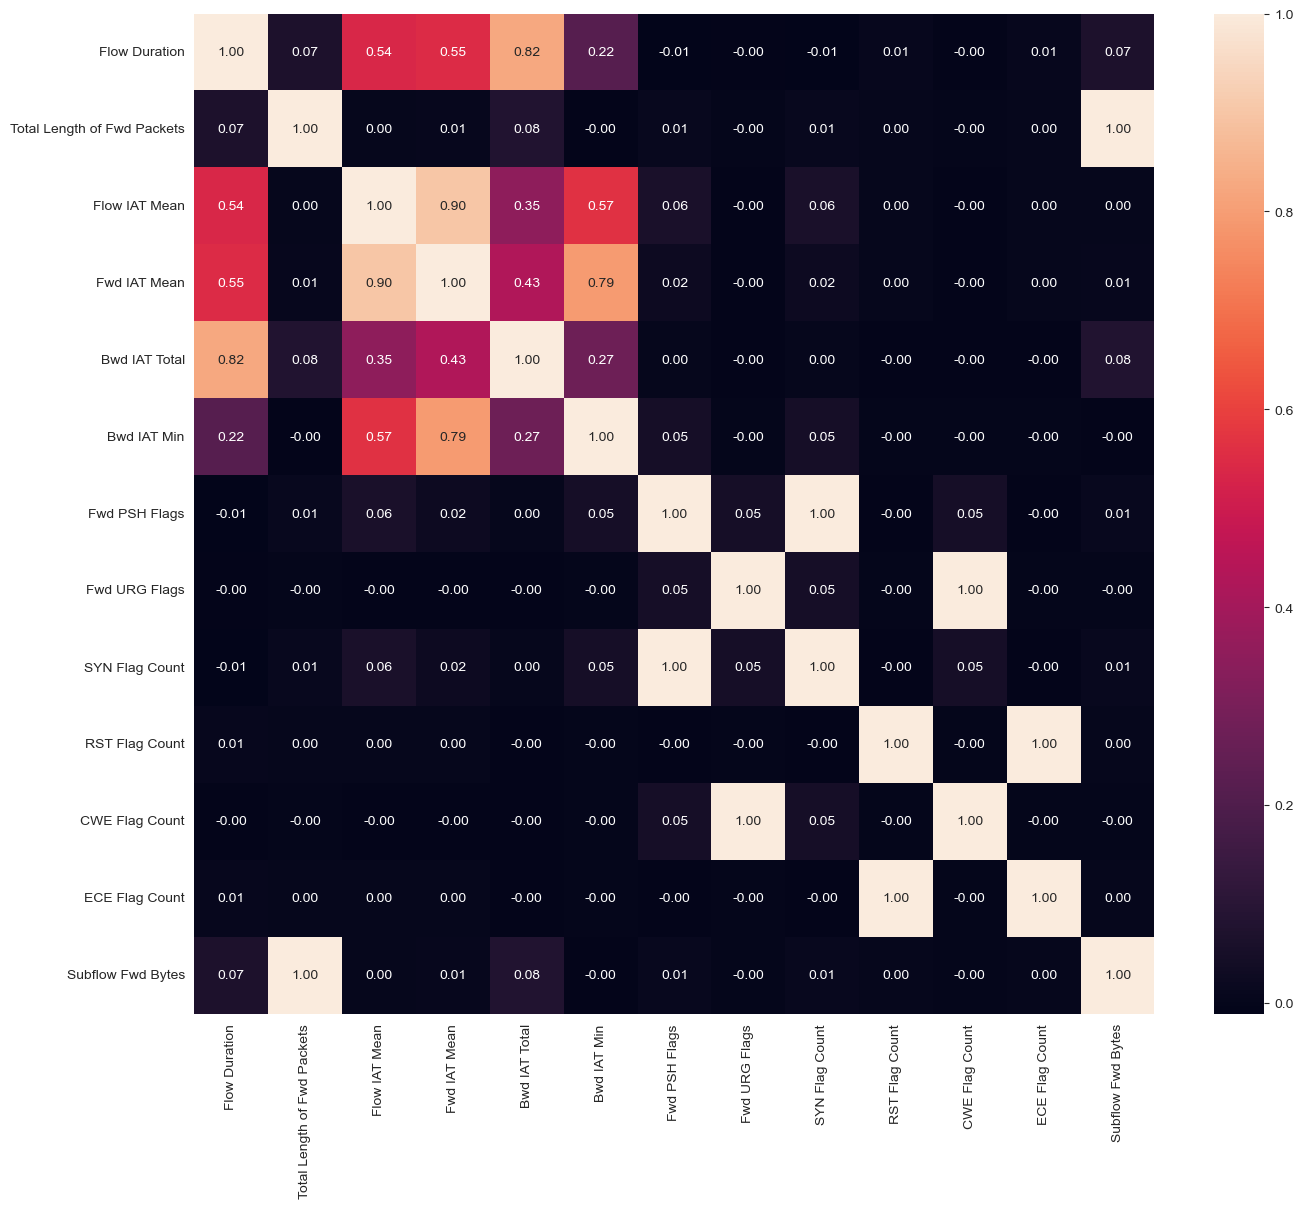

In [24]:
remaining_correlated_cols = [col for col in highly_correlated_columns]

new_corr_matrix = scaled_df[remaining_correlated_cols].corr()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0, 0, 1, 1])
sns.heatmap(new_corr_matrix, annot=True, fmt=".2f", ax=ax)

In [25]:
remaining_correlated_cols

['Flow Duration',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd IAT Mean',
 'Bwd IAT Total',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Fwd URG Flags',
 'SYN Flag Count',
 'RST Flag Count',
 'CWE Flag Count',
 'ECE Flag Count',
 'Subflow Fwd Bytes']

Using the heatmap I analyzed the columns I have to drop.

In [26]:
columns_to_drop = [
    "Total Length of Fwd Packets",
    "Fwd PSH Flags",
    "Fwd URG Flags",
    "SYN Flag Count",
    "CWE Flag Count",
    "ECE Flag Count",
    "Bwd IAT Min",
    "Fwd IAT Mean",
    "Bwd IAT Total",
    "Subflow Fwd Bytes",
]

# Check for typos
for col in columns_to_drop:
    try:
        scaled_df.drop(columns=[col])
    except KeyError:
        print(col)

In [27]:
len(columns_to_drop)

10

In [28]:
scaled_df = scaled_df.drop(columns=columns_to_drop)

In [29]:
scaled_df.shape

(2827876, 34)

In [30]:
# Let's check if there are still columns with high correlation
threshold = 0.7
highly_correlated_columns = defaultdict(list)

correlation_matrix = scaled_df.corr()

for key_col, row in correlation_matrix.iterrows():
    for with_column in row.index:
        correlation_value = row[with_column]
        if abs(correlation_value) > threshold and key_col != with_column:
            highly_correlated_columns[key_col].append((with_column, correlation_value))

remaining_correlated_cols = [col for col in highly_correlated_columns]

remaining_correlated_cols

[]

In [31]:
highly_correlated_columns

defaultdict(list, {})

Now that we have got rid of columns with high correlation among them and solve the issue of multicollinearity is time to get rid of the column with no contribution to predictions using L1 regression.

In [32]:
scaled_df.corr()

,Flow Duration,Total Backward Packets,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Mean,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Min,...,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Std,Idle Std
Flow Duration,1.000000,0.019667,-0.105380,0.143584,-0.216324,0.461787,-0.025261,-0.122429,0.536264,0.065019,...,NaN,NaN,NaN,NaN,0.098722,-0.021327,-0.001356,0.189263,0.241038,0.243131
Total Backward Packets,0.019667,1.000000,-0.002603,-0.000336,-0.004865,0.021503,0.000291,-0.002762,-0.001369,-0.000570,...,NaN,NaN,NaN,NaN,0.003225,-0.000383,0.000018,0.038962,0.006436,0.000491
Fwd Packet Length Min,-0.105380,-0.002603,1.000000,0.262773,0.291579,-0.101330,0.057987,-0.054196,-0.018258,0.002213,...,NaN,NaN,NaN,NaN,-0.141676,-0.064833,-0.001178,-0.033485,-0.030799,-0.029987
Fwd Packet Length Mean,0.143584,-0.000336,0.262773,1.000000,-0.025685,0.000702,0.100725,-0.056616,0.052678,-0.010821,...,NaN,NaN,NaN,NaN,0.046317,-0.008022,0.000045,0.093219,0.056557,0.178442
Bwd Packet Length Min,-0.216324,-0.004865,0.291579,-0.025685,1.000000,-0.145483,-0.020494,-0.149001,-0.082413,-0.027659,...,NaN,NaN,NaN,NaN,-0.280821,-0.133008,0.000260,-0.067032,-0.058061,-0.054995
Bwd Packet Length Mean,0.461787,0.021503,-0.101330,0.000702,-0.145483,1.000000,-0.026359,-0.138765,0.212668,-0.027253,...,NaN,NaN,NaN,NaN,0.104727,-0.064062,0.001147,0.076111,0.033170,0.170609
Flow Bytes/s,-0.025261,0.000291,0.057987,0.100725,-0.020494,-0.026359,1.000000,0.226101,-0.016571,-0.003166,...,NaN,NaN,NaN,NaN,-0.015337,-0.012501,0.000085,-0.007201,-0.006011,-0.006297
Flow Packets/s,-0.122429,-0.002762,-0.054196,-0.056616,-0.149001,-0.138765,0.226101,1.000000,-0.080260,-0.015335,...,NaN,NaN,NaN,NaN,-0.074076,-0.036407,0.000525,-0.035032,-0.029136,-0.030500
Flow IAT Mean,0.536264,-0.001369,-0.018258,0.052678,-0.082413,0.212668,-0.016571,-0.080260,1.000000,0.642533,...,NaN,NaN,NaN,NaN,0.020431,-0.025335,-0.000221,0.065348,0.020672,0.141241
Flow IAT Min,0.065019,-0.000570,0.002213,-0.010821,-0.027659,-0.027253,-0.003166,-0.015335,0.642533,1.000000,...,NaN,NaN,NaN,NaN,0.078811,-0.012625,0.000130,-0.000154,-0.005733,-0.004813


In [33]:
scaled_df.corr()[scaled_df.corr().isna().all()]

,Flow Duration,Total Backward Packets,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Mean,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Min,...,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Std,Idle Std
Bwd PSH Flags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bwd URG Flags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fwd Avg Bytes/Bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fwd Avg Packets/Bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fwd Avg Bulk Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bwd Avg Bytes/Bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bwd Avg Packets/Bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bwd Avg Bulk Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column with constant values will lead to return NaN in the correlation matrix.

Explanation !!!!

If a column in your dataset has the same value for every observation (i.e., it is a constant column), the standard deviation of that column will be zero. Since the correlation coefficient involves dividing by the standard deviation, dividing by zero results in an undefined value, which appears as NaN in the correlation matrix.
Example: A column like [3, 3, 3, 3] will lead to NaN correlations with all other columns.

In [34]:
constants = scaled_df.loc[:, scaled_df.std() == 0]

These columns seem to have the same value for every observation that's why the standard deviation is zero. Let's take a closer look on the dataset before the scaling.

In [35]:
df[constants.columns]

,Bwd PSH Flags,Bwd URG Flags,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
170361,0,0,0,0,0,0,0,0
170362,0,0,0,0,0,0,0,0
170363,0,0,0,0,0,0,0,0
170364,0,0,0,0,0,0,0,0


In [36]:
df[constants.columns].sum()

Bwd PSH Flags           0
Bwd URG Flags           0
Fwd Avg Bytes/Bulk      0
Fwd Avg Packets/Bulk    0
Fwd Avg Bulk Rate       0
Bwd Avg Bytes/Bulk      0
Bwd Avg Packets/Bulk    0
Bwd Avg Bulk Rate       0
dtype: int64

Now it is clear that we should excluse these columns too.

In [37]:
scaled_df = scaled_df.drop(columns=constants.columns)

In [38]:
scaled_df.corr()

,Flow Duration,Total Backward Packets,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Mean,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Min,...,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Std,Idle Std
Flow Duration,1.000000,0.019667,-0.105380,0.143584,-0.216324,0.461787,-0.025261,-0.122429,0.536264,0.065019,...,0.166701,0.028459,-0.101870,-0.147828,0.098722,-0.021327,-0.001356,0.189263,0.241038,0.243131
Total Backward Packets,0.019667,1.000000,-0.002603,-0.000336,-0.004865,0.021503,0.000291,-0.002762,-0.001369,-0.000570,...,0.006104,0.001016,-0.002847,0.003460,0.003225,-0.000383,0.000018,0.038962,0.006436,0.000491
Fwd Packet Length Min,-0.105380,-0.002603,1.000000,0.262773,0.291579,-0.101330,0.057987,-0.054196,-0.018258,0.002213,...,-0.198699,-0.109301,0.012256,0.283444,-0.141676,-0.064833,-0.001178,-0.033485,-0.030799,-0.029987
Fwd Packet Length Mean,0.143584,-0.000336,0.262773,1.000000,-0.025685,0.000702,0.100725,-0.056616,0.052678,-0.010821,...,0.079682,-0.011254,0.052480,0.039190,0.046317,-0.008022,0.000045,0.093219,0.056557,0.178442
Bwd Packet Length Min,-0.216324,-0.004865,0.291579,-0.025685,1.000000,-0.145483,-0.020494,-0.149001,-0.082413,-0.027659,...,-0.375149,-0.372829,-0.182691,0.221300,-0.280821,-0.133008,0.000260,-0.067032,-0.058061,-0.054995
Bwd Packet Length Mean,0.461787,0.021503,-0.101330,0.000702,-0.145483,1.000000,-0.026359,-0.138765,0.212668,-0.027253,...,0.211267,-0.039847,-0.161450,-0.005195,0.104727,-0.064062,0.001147,0.076111,0.033170,0.170609
Flow Bytes/s,-0.025261,0.000291,0.057987,0.100725,-0.020494,-0.026359,1.000000,0.226101,-0.016571,-0.003166,...,-0.034443,0.051971,-0.016163,-0.041283,-0.015337,-0.012501,0.000085,-0.007201,-0.006011,-0.006297
Flow Packets/s,-0.122429,-0.002762,-0.054196,-0.056616,-0.149001,-0.138765,0.226101,1.000000,-0.080260,-0.015335,...,-0.105282,0.248367,-0.027906,-0.196706,-0.074076,-0.036407,0.000525,-0.035032,-0.029136,-0.030500
Flow IAT Mean,0.536264,-0.001369,-0.018258,0.052678,-0.082413,0.212668,-0.016571,-0.080260,1.000000,0.642533,...,-0.062349,0.089263,-0.003966,-0.079179,0.020431,-0.025335,-0.000221,0.065348,0.020672,0.141241
Flow IAT Min,0.065019,-0.000570,0.002213,-0.010821,-0.027659,-0.027253,-0.003166,-0.015335,0.642533,1.000000,...,-0.033301,0.072000,0.087028,-0.050404,0.078811,-0.012625,0.000130,-0.000154,-0.005733,-0.004813


In [42]:
len(scaled_df.columns)

26

Now let's split our data into train and test dataframes. First of all, we need to shuffle them before the splitting because the data represent cyberattacks that occured during the business days of a week. Moreover, according to the description of the dataset Monday was a day without any cyberattack and all cyberattacks occured from Thursday to Friday both morning and afternoon hours.

In [43]:
from sklearn.linear_model import LassoCV

scaled_X = scaled_df.values
# Implementing Lasso Regression in the whole dataframe, not only on the train set. We want to find the most import features within the dataframe.
lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
lasso.fit(scaled_X, y)

coef = pd.Series(lasso.coef_, index=scaled_df.columns)

coef.sort_values(ascending=False)

Bwd Packet Length Mean     0.146191
FIN Flag Count             0.006617
ACK Flag Count             0.004647
Flow Duration              0.000000
Total Backward Packets    -0.000000
Active Std                -0.000000
Active Mean               -0.000000
min_seg_size_forward       0.000000
Init_Win_bytes_backward   -0.000000
Init_Win_bytes_forward    -0.000000
Down/Up Ratio             -0.000000
PSH Flag Count             0.000000
RST Flag Count            -0.000000
Bwd Packets/s              0.000000
Bwd Header Length          0.000000
Fwd Header Length          0.000000
Bwd IAT Std                0.000000
Flow IAT Min               0.000000
Flow IAT Mean              0.000000
Flow Packets/s             0.000000
Flow Bytes/s              -0.000000
Fwd Packet Length Mean    -0.000000
Fwd Packet Length Min     -0.000000
Idle Std                   0.000000
URG Flag Count            -0.009828
Bwd Packet Length Min     -0.054043
dtype: float64

In [44]:
len(coef[coef != 0])

5

In [45]:
coef[coef != 0]

Bwd Packet Length Min    -0.054043
Bwd Packet Length Mean    0.146191
FIN Flag Count            0.006617
ACK Flag Count            0.004647
URG Flag Count           -0.009828
dtype: float64

In [46]:
important_features = list(coef[coef != 0].index)

In [47]:
from sklearn.model_selection import train_test_split

# scaled_X = scaled_df[important_features].values # recreate the scaled_X after dropping the columns from scaled_df
scaled_X = scaled_df.values
# Stratify argument is to ensure that the distribution of target variable will be retained to both train and test df
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42, stratify=y)

print(
    "Cyberattacks percentage against benign traffic within the train dataset:",
    f"{y_train.value_counts().iloc[1] / len(y_train):2f}%",
)
print(
    "Cyberattacks percentage against benign traffic within the test dataset:",
    f"{y_train.value_counts().iloc[1] / len(y_train):2f}%",
)

Cyberattacks percentage against benign traffic within the train dataset: 0.196811%
Cyberattacks percentage against benign traffic within the test dataset: 0.196811%


### Binary Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_weights = {0: 1.0, 1: 5.0}  # Increase weight for class 1(cyberattacks) because it is underrepresented.
log_model = LogisticRegression(class_weight=class_weights, max_iter=1000)
log_model.fit(X_train, y_train)
predictions = log_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
confusion_mat = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)


print("Logistic Regression Model Accuracy:" "\n", accuracy, end="\n")

print("Confusion matrix:" "\n", confusion_mat, end="\n")

print("Classification report:" "\n", classification_rep, end="\n")

Logistic Regression Model Accuracy:
 0.8256485423709634
Confusion matrix:
 [[359345  94920]
 [  3689 107622]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88    454265
           1       0.53      0.97      0.69    111311

    accuracy                           0.83    565576
   macro avg       0.76      0.88      0.78    565576
weighted avg       0.90      0.83      0.84    565576



### Binary Gaussian Naive Bayes classifier

In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_confusion_mat = confusion_matrix(y_test, nb_predictions)
nb_classification_rep = classification_report(y_test, nb_predictions)

print("Naive Bayes Model Accuracy:\n", nb_accuracy, end="\n")
print("Naive Bayes Confusion Matrix:\n", nb_confusion_mat, end="\n")
print("Naive Bayes Classification Report:\n", nb_classification_rep, end="\n")

Naive Bayes Model Accuracy:
 0.40646703537632434
Naive Bayes Confusion Matrix:
 [[120289 333976]
 [  1712 109599]]
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.26      0.42    454265
           1       0.25      0.98      0.40    111311

    accuracy                           0.41    565576
   macro avg       0.62      0.62      0.41    565576
weighted avg       0.84      0.41      0.41    565576



### Binary Decision tree classifier

In [50]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree with class weights
dt_model = DecisionTreeClassifier(class_weight=class_weights, random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_confusion_mat = confusion_matrix(y_test, dt_predictions)
dt_classification_rep = classification_report(y_test, dt_predictions)

print("Decision Tree Model Accuracy:\n", dt_accuracy, end="\n")
print("Decision Tree Confusion Matrix:\n", dt_confusion_mat, end="\n")
print("Decision Tree Classification Report:\n", dt_classification_rep, end="\n")

Decision Tree Model Accuracy:
 0.998696903687568
Decision Tree Confusion Matrix:
 [[453792    473]
 [   264 111047]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    454265
           1       1.00      1.00      1.00    111311

    accuracy                           1.00    565576
   macro avg       1.00      1.00      1.00    565576
weighted avg       1.00      1.00      1.00    565576



KNeighbours takes too much time to run so we used a small batch of the dataset to tune the model....

#### K-Nearest Neighbors

In [51]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []

# Will take some time
for i in range(1, 10):

    knn = KNeighborsClassifier(n_neighbors=i, weights="distance", n_jobs=4)
    knn.fit(X_train[:10000], y_train[:10000])
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

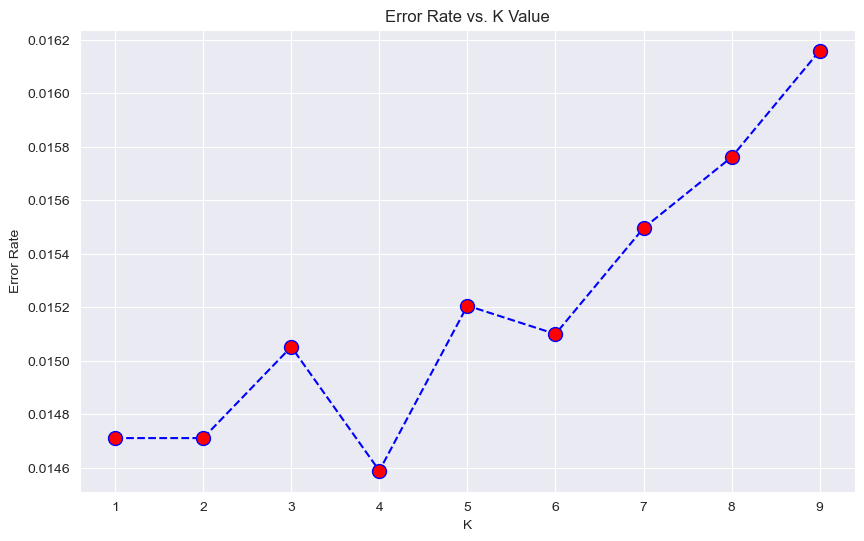

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), error_rate, color="blue", linestyle="dashed", marker="o", markerfacecolor="red", markersize=10)
plt.title("Error Rate vs. K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")

Batch processing is required due to lack of RAM

In [53]:
knn_model = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
batch_size = 1000
n_batches = int(np.ceil(10000 / batch_size))
for i in tqdm(range(n_batches), desc="Training  KNN model"):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X_train = X_train[start:end]
    batch_y_train = y_train[start:end]
    knn_model.fit(batch_X_train, batch_y_train)


knn_predictions = knn_model.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_confusion_mat = confusion_matrix(y_test, knn_predictions)
knn_classification_rep = classification_report(y_test, knn_predictions)

print("KNN Model Accuracy:\n", knn_accuracy, end="\n")
print("KNN Confusion Matrix:\n", knn_confusion_mat, end="\n")
print("KNN Classification Report:\n", knn_classification_rep, end="\n")

Training  KNN model: 100%|██████████| 10/10 [00:00<00:00, 1886.86it/s]


KNN Model Accuracy:
 0.9414490713891679
KNN Confusion Matrix:
 [[442021  12244]
 [ 20871  90440]]
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96    454265
           1       0.88      0.81      0.85    111311

    accuracy                           0.94    565576
   macro avg       0.92      0.89      0.90    565576
weighted avg       0.94      0.94      0.94    565576



### Section 2

As we can see, DecisionTree Classifier predicted almost perfect all if an observation reflected a cyberattack or a benign traffic.

In the section below, we will keep only the cyberattacks and, we will try to predict the type of the attack.

Boiling down, our prediction methodology includes two stages:

1. predict if an observation is a cyberattack or not 
2. then to predict the type of cyberattack.

In [54]:
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,NumericLabel
0,166,1,1,0,0,0,0,0.0,0.0,0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,0
1,83,1,2,0,0,0,0,0.0,0.0,0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,0
2,99947,1,1,48,48,48,48,48.0,0.0,48,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,0
3,37017,1,1,48,48,48,48,48.0,0.0,48,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,0
4,111161336,147,0,0,0,0,0,0.0,0.0,0,...,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN,0


In [55]:
new_df = df[df["NumericLabel"] == 1]  # keep only the cyberattacks.

In [56]:
"Label" in new_df.columns

True

In [57]:
"Label" in scaled_df.columns

False

In our new dataframe that contains only the cyberattacks, we will use the same columns with the binary classification problem.

Meaning we will drop the columns that provokes the multicollinearity.

In [58]:
new_df = new_df[list(scaled_df.columns) + ["Label"]]

In [59]:
new_df.shape

(556556, 27)

In [60]:
new_df["Label"].value_counts()

Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

Let's also drop the rows which describe cyberattacks whose type is very underrepresented.

In [61]:
new_df = new_df[~new_df["Label"].isin(["Heartbleed", "Web Attack � Sql Injection", "Infiltration"])]
new_df

,Flow Duration,Total Backward Packets,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Mean,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Min,...,ACK Flag Count,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Std,Idle Std,Label
24072,60202640,9,0,35.777778,0,28.444444,9.600908,0.298990,3.541332e+06,47,...,0,0,1,29200,110,32,63678.2,22252.53596,34941.27201,Bot
24677,57891,1,0,0.000000,0,0.000000,0.000000,34.547684,5.789100e+04,57891,...,1,1,1,237,110,32,0.0,0.00000,0.00000,Bot
56376,134812,3,0,51.500000,0,44.666667,2522.030680,51.924161,2.246867e+04,123,...,0,0,0,8192,237,20,0.0,0.00000,0.00000,Bot
56401,84,1,6,6.000000,6,6.000000,142857.142900,23809.523810,8.400000e+01,84,...,1,1,1,237,256,20,0.0,0.00000,0.00000,Bot
56596,127781,3,0,51.500000,0,44.666667,2660.802467,54.781227,2.129683e+04,75,...,0,0,0,8192,237,20,0.0,0.00000,0.00000,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86050,5029253,7,0,186.111111,0,806.714286,1455.882216,3.181387,3.352835e+05,4,...,0,0,0,29200,262,32,0.0,0.00000,0.00000,Web Attack � XSS
86051,5013370,6,0,105.714286,0,1172.833333,1551.251952,2.593066,4.177808e+05,33,...,0,0,0,29200,243,32,0.0,0.00000,0.00000,Web Attack � XSS
86062,18,1,0,0.000000,0,0.000000,0.000000,111111.111100,1.800000e+01,18,...,1,1,1,330,262,32,0.0,0.00000,0.00000,Web Attack � XSS
86063,13,1,0,0.000000,0,0.000000,0.000000,153846.153800,1.300000e+01,13,...,1,1,1,339,243,32,0.0,0.00000,0.00000,Web Attack � XSS


Notice that still there is a huge imbalance.

In [62]:
new_df["Label"].value_counts().sum()

556488

In [63]:
new_df.columns

Index(['Flow Duration', 'Total Backward Packets', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Min', 'Bwd IAT Std', 'Fwd Header Length',
       'Bwd Header Length', 'Bwd Packets/s', 'FIN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Active Mean', 'Active Std', 'Idle Std',
       'Label'],
      dtype='object')

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

new_X = new_df.drop(columns=["Label"]).values
new_y = new_df["Label"]

le = LabelEncoder()
y_encoded = le.fit_transform(new_y)

scaler = StandardScaler()
scaler.fit(new_X)
scaled_new_X = scaler.transform(new_X)

In [65]:
# Create a dictionary where the key is the label and the key the new numeric value assigned from the LabelEncoder
s = {(label, number) for label, number in zip(new_y, y_encoded)}
d = {label: number for label, number in s}

Now, let's extract the most useful features for our multinomial classification problem using logistic regression.

In [66]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    new_X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

The "balanced" mode uses the values of y to automatically adjust
        weights inversely proportional to class frequencies in the input data
        as ``n_samples / (n_classes * np.bincount(y))``.
        
Moreover, according to the documentation the paramater multinomial is deprecated.
multi_class : {'auto', 'ovr', 'multinomial'}, default='auto'
        If the option chosen is 'ovr', then a binary problem is fit for each
        label. For 'multinomial' the loss minimised is the multinomial loss fit
        across the entire probability distribution, *even when the data is
        binary*. 'multinomial' is unavailable when solver='liblinear'.
        'auto' selects 'ovr' if the data is binary, or if solver='liblinear',
        and otherwise selects 'multinomial'.
        
elif self.multi_class in ("multinomial", "auto"):

    warnings.warn(
    
        (
        
            "'multi_class' was deprecated in version 1.5 and will be removed in"
            
            " 1.7. From then on, it will always use 'multinomial'."
            
            " Leave it to its default value to avoid this warning."
            
        ),
        
        FutureWarning,


In [67]:
mult_log_reg = LogisticRegression(class_weight="balanced", max_iter=20000, solver="saga", penalty="l1", n_jobs=-1)

batch_size = 1000
n_batches = int(np.ceil(10000 / batch_size))
for i in tqdm(range(n_batches), desc="Training logistic regression model"):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X_train = new_X_train[start:end]
    batch_y_train = new_y_train[start:end]
    mult_log_reg.fit(batch_X_train, batch_y_train)

Training logistic regression model:  30%|███       | 3/10 [00:23<00:50,  7.28s/it]/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training logistic regression model:  40%|████      | 4/10 [00:47<01:25, 14.17s/it]/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training logistic regression model: 100%|██████████| 10/10 [02:01<00:00, 12.14s/it]


In [68]:
coef = mult_log_reg.coef_
coef_df = pd.DataFrame(data=coef, index=list(new_df["Label"].unique()), columns=new_df.drop(columns=["Label"]).columns)

In [69]:
coef_df

,Flow Duration,Total Backward Packets,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Mean,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Min,...,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Std,Idle Std
Bot,2.947687e-07,5.667216e-11,-8.635684e-12,-8.313607e-11,1.526669e-10,-2.996604e-09,-8.326430e-07,-5.123253e-07,-2.027659e-07,-3.517138e-07,...,2.076516e-11,-3.911906e-12,-1.611275e-12,2.092869e-11,8.117402e-08,-6.519213e-08,4.420102e-10,-1.851913e-07,-5.903105e-11,-1.935988e-08
PortScan,2.583460e-07,1.162706e-11,5.208867e-11,-5.261903e-11,-3.655137e-11,2.874836e-08,3.759752e-07,-5.536037e-07,5.941042e-07,-9.916116e-07,...,-2.934054e-12,6.895498e-12,-1.610237e-12,7.041283e-12,-2.505253e-07,-1.799671e-07,-1.660030e-10,-4.420634e-07,-1.477623e-08,1.521041e-07
DDoS,3.138300e-07,4.508753e-12,-5.502409e-10,2.808480e-10,-3.250638e-11,2.157806e-08,-8.266002e-07,-5.128245e-07,-6.454926e-07,3.128608e-06,...,1.222550e-12,-3.701390e-12,-3.132840e-12,-9.730783e-12,1.733545e-07,-6.215111e-08,-8.212316e-11,2.595123e-07,-1.447204e-07,-6.811918e-07
FTP-Patator,3.623335e-07,-1.498839e-10,-8.714093e-12,-4.323793e-10,-3.692423e-11,-1.160687e-08,-5.420650e-09,3.047344e-06,-2.903889e-07,-4.231194e-07,...,-2.245957e-11,3.099019e-12,-1.744735e-12,-1.233547e-11,-5.231051e-07,-8.946421e-08,-5.411332e-10,-2.424269e-06,-1.562251e-06,5.570257e-08
SSH-Patator,-9.167487e-07,-3.507236e-11,1.595358e-09,1.485264e-09,-2.337662e-11,-5.812427e-09,1.663003e-06,-1.440582e-06,4.017025e-06,-3.509748e-07,...,-1.865294e-11,-2.032727e-12,0.000000e+00,-8.727595e-12,-4.199808e-07,-2.411968e-07,-6.578053e-10,3.822086e-06,-1.801346e-07,1.059564e-06
DoS slowloris,3.427266e-08,-4.697011e-11,-8.687151e-11,-1.958030e-10,-3.120814e-11,-6.992510e-09,-8.417464e-07,-5.123131e-07,4.741095e-07,2.146760e-06,...,-1.273732e-12,-4.557951e-12,-1.832377e-12,-1.022643e-11,7.261425e-08,-6.189964e-08,-1.015319e-10,5.213229e-07,1.954789e-06,4.620622e-07
DoS Slowhttptest,4.824959e-07,2.095390e-11,-8.933972e-10,-1.132997e-09,-4.757299e-11,-9.327859e-09,1.740173e-06,8.353736e-07,-2.611049e-06,-1.333245e-07,...,-5.264757e-12,7.452705e-12,-1.657662e-12,-5.619256e-12,-2.434436e-08,-1.876723e-08,1.017429e-10,-5.021368e-07,-4.761156e-08,-2.101685e-07
DoS Hulk,-1.638233e-06,1.630924e-11,-3.909646e-11,-7.965625e-11,1.590159e-10,-1.994273e-09,1.245828e-06,5.864215e-07,-3.684792e-07,-3.330154e-08,...,2.536628e-11,-4.479873e-12,-1.660197e-12,2.266280e-11,4.106168e-07,8.373092e-10,6.898114e-10,-5.500516e-10,-5.888397e-11,-8.172511e-10
DoS GoldenEye,6.229116e-07,1.604290e-10,-6.684655e-12,4.131407e-10,-2.832465e-11,-4.795578e-09,-8.499549e-07,8.780155e-08,-4.479534e-06,-9.364916e-08,...,-2.752597e-12,1.696534e-11,1.937920e-11,1.693559e-11,1.774044e-08,-7.092043e-09,4.795598e-10,-4.223007e-07,-1.771699e-09,-4.546090e-08
Web Attack � Brute Force,9.234678e-08,-1.913416e-11,-2.546642e-11,-9.966337e-11,-3.639185e-11,-3.384019e-09,-8.343215e-07,-5.126479e-07,1.752500e-06,-1.443090e-06,...,3.320571e-12,-7.278897e-12,-1.616277e-12,-9.945101e-12,2.357931e-07,3.668797e-07,-7.479586e-11,-3.108306e-07,-1.025383e-09,-3.824300e-07


In [70]:
coef_df.abs().max(axis=0).apply(lambda x: f"{x:.12f}").sort_values(ascending=False)

Flow IAT Mean              0.000004479534
Active Mean                0.000003822086
Flow IAT Min               0.000003128608
Flow Packets/s             0.000003047344
Active Std                 0.000001954789
Flow Bytes/s               0.000001740173
Bwd IAT Std                0.000001660033
Flow Duration              0.000001638233
Idle Std                   0.000001059564
Bwd Packets/s              0.000000751944
Init_Win_bytes_forward     0.000000523105
Init_Win_bytes_backward    0.000000366880
Bwd Packet Length Mean     0.000000028748
Bwd Header Length          0.000000005349
Fwd Header Length          0.000000004164
Fwd Packet Length Min      0.000000001595
Fwd Packet Length Mean     0.000000001485
min_seg_size_forward       0.000000000690
Total Backward Packets     0.000000000160
Bwd Packet Length Min      0.000000000159
PSH Flag Count             0.000000000025
Down/Up Ratio              0.000000000023
URG Flag Count             0.000000000019
ACK Flag Count             0.00000

In [71]:
threshold = 1e-7

# Identify columns where all values are close to zero
cols_to_drop = coef_df.columns[(coef_df.abs().max() < threshold)]

##### Labels and Numeric Values matching

In [72]:
d

{'Web Attack � XSS': 10,
 'DoS slowloris': 5,
 'DoS Hulk': 3,
 'DoS Slowhttptest': 4,
 'FTP-Patator': 6,
 'SSH-Patator': 8,
 'Web Attack � Brute Force': 9,
 'PortScan': 7,
 'Bot': 0,
 'DDoS': 1,
 'DoS GoldenEye': 2}

### Multinomial Logistic Regression

In [73]:
new_X = new_df.drop(columns=["Label"] + list(cols_to_drop)).values
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    new_X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


multi_log_model = LogisticRegression(class_weight="balanced", max_iter=15000, solver="saga", n_jobs=-1)
batch_size = 15000
n_batches = int(np.ceil(len(new_X_train) / batch_size))

for i in tqdm(range(n_batches), desc="Training logistic regression model"):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X_train = new_X_train[start:end]
    batch_y_train = new_y_train[start:end]
    multi_log_model.fit(batch_X_train, batch_y_train)

predictions = multi_log_model.predict(new_X_test)

accuracy = accuracy_score(new_y_test, predictions)
confusion_mat = confusion_matrix(new_y_test, predictions)
classification_rep = classification_report(new_y_test, predictions, zero_division=1)


print("Multiclass Logistic Regression Model Accuracy:" "\n", accuracy, end="\n")

print("Confusion matrix:" "\n", confusion_mat, end="\n")

print("Classification report:" "\n", classification_rep, end="\n")

Training logistic regression model: 100%|██████████| 30/30 [16:03<00:00, 32.13s/it]


Multiclass Logistic Regression Model Accuracy:
 0.45842692591061834
Confusion matrix:
 [[    0     0    13     0   121     0   147     0     0   110     0]
 [    0  3811  4630   661  7268  4704    15     0     8  4508     0]
 [    0     0   993   936    55    73     2     0     0     0     0]
 [    0   716   336 40189  3182   446   823     7   153   167     6]
 [    0     0    79     2   880    84     2     0    25    28     0]
 [    0    11   355     9    70   573   105     0     3    32     1]
 [    0     0     3     1     0     1  1582     0     0     0     0]
 [    0     0    13     4    17    50 29133  2423     0     6   115]
 [    0     0     2   596     0     0     8     3   570     0     1]
 [    0     0    17    31     0   233     0     0    18     0     2]
 [    0     0     0     6     0   120     1     0     2     0     1]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       391
           1       0

### Gaussian Naive Bayes model

In [74]:
gnb = GaussianNB()
batch_size = 10000
n_batches = int(np.ceil(len(new_X_train) / batch_size))

for i in tqdm(range(n_batches), desc="Training Naive Bayes model"):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X_train = new_X_train[start:end]
    batch_y_train = new_y_train[start:end]
    gnb.partial_fit(batch_X_train, batch_y_train, classes=np.unique(new_y_train))

predictions = gnb.predict(new_X_test)

accuracy = accuracy_score(new_y_test, predictions)
confusion_mat = confusion_matrix(new_y_test, predictions)
classification_rep = classification_report(new_y_test, predictions, zero_division=1)


print("Multiclass Naive Bayes Model Accuracy:" "\n", accuracy, end="\n")

print("Naive Bayes Confusion matrix:" "\n", confusion_mat, end="\n")

print("Naive Bayes Classification report:" "\n", classification_rep, end="\n")

Training Naive Bayes model: 100%|██████████| 45/45 [00:00<00:00, 119.01it/s]


Multiclass Naive Bayes Model Accuracy:
 0.3161242789627846
Naive Bayes Confusion matrix:
 [[  158     1     0     0     0     0     0     0   232     0     0]
 [ 5790  4713   135     4     3     4   133   160  7501  7162     0]
 [    0     3   908     0     0    36     0     0   224   888     0]
 [  239  9916    18 17947     0   276 11437    13  5999   178     2]
 [   23    65    74   129    56   674    22     0    28    28     1]
 [  131     4   573    38    10   360     1     0    34     5     3]
 [  567     0     0     0     0     0   237     3   779     0     1]
 [15753     0    49     0     0     0  6307  9492    36   123     1]
 [    2     0     0     0     0     0     0     2  1176     0     0]
 [    0     0     0     0     0     0     0     0    49    17   235]
 [    0     0     1     0     0     0     0     0     8     1   120]]
Naive Bayes Classification report:
               precision    recall  f1-score   support

           0       0.01      0.40      0.01       391
     

### Nearest Neighbours model

In [75]:
knn = KNeighborsClassifier(n_neighbors=4, weights="distance")
batch_size = 10000
n_batches = int(np.ceil(len(new_X_train) / batch_size))

for i in tqdm(range(n_batches), desc="Training KNN model"):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X_train = new_X_train[start:end]
    batch_y_train = new_y_train[start:end]
    knn.fit(batch_X_train, batch_y_train)

predictions = knn.predict(new_X_test)

accuracy = accuracy_score(new_y_test, predictions)
confusion_mat = confusion_matrix(new_y_test, predictions)
classification_rep = classification_report(new_y_test, predictions, zero_division=1)


print("Multiclass KNN Model Accuracy:" "\n", accuracy, end="\n")

print("KNN Confusion matrix:" "\n", confusion_mat, end="\n")

print("KNN Classification report:" "\n", classification_rep, end="\n")

Training KNN model: 100%|██████████| 45/45 [00:00<00:00, 365.71it/s]


Multiclass KNN Model Accuracy:
 0.9808352351345038
KNN Confusion matrix:
 [[  277    19     0     0     6     0     5    84     0     0     0]
 [    3 25108     4   348     2     1    50    10     3    51    25]
 [    0    11  1927    24    68    21     0     0     8     0     0]
 [   38   309     3 45575    19     3     0    47    30     1     0]
 [    7    60     1    32   970    20     6     3     1     0     0]
 [    9    54     2    72    40   873     7   100     2     0     0]
 [    3    16     0     0     0     0  1537    29     2     0     0]
 [    0    10    13    41     0     6    61 31629     0     1     0]
 [    0    10     0    11     0     0     3     0  1136    20     0]
 [    0    69    17    20     0     0     0     0    26   106    63]
 [    0    32     3     5     0     0     0     0     1    62    27]]
KNN Classification report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76       391
           1       0.98      

In [76]:
multi_decision_tree = DecisionTreeClassifier(class_weight="balanced", random_state=42)
batch_size = 10000
n_batches = int(np.ceil(len(new_X_train) / batch_size))

for i in tqdm(range(n_batches), desc="Training KNN model"):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X_train = new_X_train[start:end]
    batch_y_train = new_y_train[start:end]
    multi_decision_tree.fit(batch_X_train, batch_y_train)

predictions = multi_decision_tree.predict(new_X_test)

accuracy = accuracy_score(new_y_test, predictions)
confusion_mat = confusion_matrix(new_y_test, predictions)
classification_rep = classification_report(new_y_test, predictions, zero_division=1)


print("Multiclass Decision Tree Model Accuracy:" "\n", accuracy, end="\n")

print("Decision Tree Confusion matrix:" "\n", confusion_mat, end="\n")

print("Decision Tree Classification report:" "\n", classification_rep, end="\n")

Training KNN model: 100%|██████████| 45/45 [00:01<00:00, 29.44it/s]


Multiclass Decision Tree Model Accuracy:
 0.9926863016406404
Decision Tree Confusion matrix:
 [[  391     0     0     0     0     0     0     0     0     0     0]
 [    1 25583     0    15     6     0     0     0     0     0     0]
 [    3     0  2000    14    30     1     0     0    11     0     0]
 [   12    36    23 45944     0     3     0     0     0     6     1]
 [    0    11     1    22  1001    33     0     7     2    23     0]
 [    1     1    49    37    66   973     0     1     1    30     0]
 [    3     3     0    13     0     5  1549    13     0     1     0]
 [    0     1     1    12    22    13    10 31693     0     9     0]
 [    2     0     8     0     0     1     1     4  1164     0     0]
 [    0    11    23     3     0    16     0     0    16   156    76]
 [    0     1     5     3     1     2     0     0     0    88    30]]
Decision Tree Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       391